![](images/gpulab.png)

# PyTorch Image Classifier Demonstration

The following [GPULab](https://gpulab.io) demonstration uses [PyTorch](https://pytorch.org/) to create and train a flower species image [classifier](https://towardsdatascience.com/machine-learning-classifiers-a5cc4e1b0623) using the [102 Category Flower Dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) available from Oxford's [Visual Geometry Group](https://www.robots.ox.ac.uk/~vgg/index.html). 

Import all dependencies.

In [1]:
import os
import requests
import tarfile
import scipy.io as sio
import numpy as np
import shutil
import random
from IPython.display import Image as NBImage
from collections import OrderedDict
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt

Set a few default values and paths.

In [2]:
data_dir = "./data/flowers/"
source_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/"
image_source = "102flowers.tgz"
label_source = "imagelabels.mat"
training_dir = 'training/'
validation_dir = 'validation/'
test_dir = 'test/'

## Aquire Source Data

Download data lables and if it does not exists using the [requests](https://requests.readthedocs.io/en/master/) library.

In [3]:
# create a data directory if it does not exist
if os.path.isdir(data_dir) is False:
    os.mkdir(data_dir)

# download source data if it does not exist
for file in [image_source, label_source]:
    if os.path.isfile(data_dir + file) is False:
        print(f"{data_dir + file} is not found, downloading...")
        r = requests.get(source_url + file)
        with open(data_dir + file, 'wb') as f:
            f.write(r.content)

Extract images from the downloaded [tarfile](https://docs.python.org/3/library/tarfile.html) fontaining 8,189 flower images.

In [4]:
if os.path.isfile(data_dir + "jpg/image_00001.jpg") is False:
    images_tar = tarfile.open(data_dir + image_source)
    images_tar.extractall(data_dir)
    images_tar.close()

## Sort Data

Seperate data into training, validation and test sets, reate a directory for each if they do not already exist.

In [5]:
for directory in [training_dir, validation_dir, test_dir]:
    if os.path.isdir(data_dir + directory) is False:
        os.mkdir(data_dir + directory)

This demonstration uses the [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class from [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) to load images. Images must be organized in subdirectories naed as the category for the images it contains. 

Use [scipy.io](https://docs.scipy.org/doc/scipy/reference/io.html) to load the image labels from the downloaded MATLAB® file (.mat). Alternatively, use the GPULab Octave kernel to work directly with most MATLAB-style files. 

In [6]:
labels_mat = sio.loadmat(data_dir + "imagelabels.mat")

Ensure the lables are accessable. The label array should contain 8189 elements representing a numberic category for each of the 8,189 flower images.

In [7]:
labels = np.array(labels_mat['labels'][0])
len(labels) == 8189

True

Create a random index for sorting files using the length of the label set. Split the random index list into three groups: ~70% into a training set, ~20% into a validation set and ~10% into a test set. 

In [8]:
index_n = len(labels)
image_index = np.arange(index_n)
np.random.shuffle(image_index)

t_n = round(index_n * .70)
v_n = round(index_n * .20)

# create a dictionary of directories and a range of label indexes
idx_dict = {
    training_dir: image_index[0:t_n],
    validation_dir: image_index[t_n:t_n+v_n],
    test_dir: image_index[t_n+v_n:],
}

# ensure the indexes add up to the total numer of lables
(len(idx_dict[training_dir])
 + len(idx_dict[validation_dir])
 + len(idx_dict[test_dir])) == index_n

True

Move files to their proper folders.

`labels` holds the category value of image number (starting at 1) to its index number - 1 (zero based index)  

In [9]:
for d in idx_dict:
    for idx in idx_dict[d]:
        file_name = f"image_{idx+1:05d}.jpg"
        source_file = f"{data_dir}jpg/{file_name}"
        dest_dir = f"{data_dir}{d}{labels[idx]}"
        dest_file = f"{dest_dir}/{file_name}"
        # print(f"{source_file} -> {dest_file}")
        if os.path.isdir(dest_dir) is False:
            os.mkdir(dest_dir)
        if os.path.isfile(source_file) is True:
            shutil.move(source_file, dest_file)

## Review Labels


In [10]:
text_labels = ["pink primrose", "hard-leaved pocket orchid",
               "canterbury bells", "sweet pea", "english marigold",
               "tiger lily", "moon orchid", "bird of paradise", "monkshood",
               "globe thistle", "snapdragon", "colt's foot", "king protea",
               "spear thistle", "yellow iris", "globe-flower", 
               "purple coneflower", "peruvian lily", "balloon flower",
               "giant white arum lily", "fire lily", "pincushion flower",
               "fritillary", "red ginger", "grape hyacinth", "corn poppy",
               "prince of wales feathers", "stemless gentian", "artichoke",
               "sweet william", "carnation", "garden phlox", "love in the mist",
               "mexican aster", "alpine sea holly", "ruby-lipped cattleya",
               "cape flower", "great masterwort", "siam tulip", "lenten rose",
               "barbeton daisy", "daffodil", "sword lily", "poinsettia",
               "bolero deep blue", "wallflower", "marigold", "buttercup",
               "oxeye daisy", "common dandelion", "petunia", "wild pansy",
               "primula", "sunflower", "pelargonium", "bishop of llandaff",
               "gaura", "geranium", "orange dahlia", "pink-yellow dahlia",
               "cautleya spicata", "japanese anemone", "black-eyed susan",
               "silverbush", "californian poppy", "osteospermum",
               "spring crocus", "bearded iris", "windflower", "tree poppy",
               "gazania", "azalea", "water lily", "rose", "thorn apple",
               "morning glory", "passion flower", "lotus lotus", "toad lily",
               "anthurium", "frangipani", "clematis", "hibiscus", "columbine",
               "desert-rose", "tree mallow", "magnolia", "cyclamen",
               "watercress", "canna lily", "hippeastrum", "bee balm",
               "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
               "mexican petunia", "bromelia", "blanket flower",
               "trumpet creeper", "blackberry lily"]

print(f"text_labels holds {len(text_labels)} category names"
      " ordered by the label id.")

text_labels holds 102 category names ordered by the label id.


Category 6 is tiger lily:


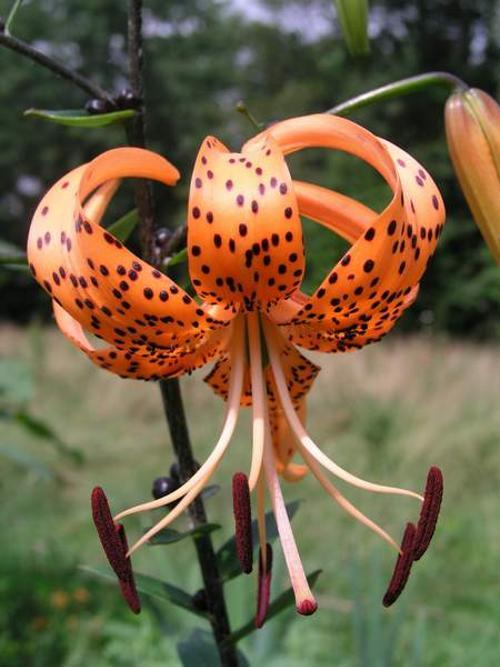

In [11]:
cat = 6
print(f"Category {cat} is {text_labels[cat - 1]}:")

cat_dir = data_dir+training_dir+str(cat)+'/'
random_file = random.choice(os.listdir(cat_dir))
NBImage(filename=cat_dir+random_file)

## Load and Transform Data

TBD

In [12]:
# pre-trained network expectations
# see: https://pytorch.org/docs/stable/torchvision/models.html
expected_means = [0.485, 0.456, 0.406]
expected_std = [0.229, 0.224, 0.225]
max_img_size = 224
batch_size = 32

# transforms for the training, validation, and testing sets
tfx = {
    "training": transforms.Compose([transforms.RandomHorizontalFlip(p=0.25),
                                    transforms.RandomRotation(25),
                                    transforms.RandomGrayscale(p=0.02),
                                    transforms.RandomResizedCrop(max_img_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize(expected_means,
                                                         expected_std)]),

    "validation": transforms.Compose([transforms.Resize(max_img_size + 1),
                                      transforms.CenterCrop(max_img_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(expected_means,
                                                           expected_std)]),

    "testing": transforms.Compose([transforms.Resize(max_img_size + 1),
                                   transforms.CenterCrop(max_img_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(expected_means,
                                                        expected_std)])

}

# load the datasets with ImageFolder class
flower_datasets = {
    "training": datasets.ImageFolder(data_dir+training_dir,
                                     transform=tfx["training"]),

    "validation": datasets.ImageFolder(data_dir+validation_dir,
                                       transform=tfx["validation"]),

    "testing": datasets.ImageFolder(data_dir+test_dir, 
                                    transform=tfx["testing"])
}

# define the dataloaders using the image datasets and the trainforms
dataloaders = {
    "training": torch.utils.data.DataLoader(flower_datasets["training"],
                                            batch_size=batch_size,
                                            shuffle=True),

    "validation": torch.utils.data.DataLoader(flower_datasets["validation"],
                                              batch_size=batch_size),

    "testing": torch.utils.data.DataLoader(flower_datasets["testing"],
                                           batch_size=batch_size)
}

## Construct Network

TBD

In [13]:
# Get model Output Size = Number of Categories
output_size = len(text_labels)

# Using VGG16.
nn_model = models.vgg16(pretrained=True)

# Input size from current classifier
input_size = nn_model.classifier[0].in_features
hidden_size = [
    (input_size // 8),
    (input_size // 32)
]

# Prevent backpropigation on parameters
for param in nn_model.parameters():
    param.requires_grad = False

# Create nn.Module with Sequential using an OrderedDict
# See https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential
classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(input_size, hidden_size[0])),
        ('relu1', nn.ReLU()),
        ('dropout', nn.Dropout(p=0.15)),
        ('fc2', nn.Linear(hidden_size[0], hidden_size[1])),
        ('relu2', nn.ReLU()),
        ('dropout', nn.Dropout(p=0.15)),
        ('output', nn.Linear(hidden_size[1], output_size)),
        # LogSoftmax is needed by NLLLoss criterion
        ('softmax', nn.LogSoftmax(dim=1))
    ]))

# Replace classifier
nn_model.classifier = classifier

hidden_size

[3136, 784]

## Train Network

TBD

In [14]:
torch.cuda.is_available()

True

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [16]:
# hyperparameters
# https://en.wikipedia.org/wiki/Hyperparameter
epochs = 5
learning_rate = 0.001
chk_every = 50

# Start clean by setting gradients of all parameters to zero.
nn_model.zero_grad()

# The negative log likelihood loss as criterion.
criterion = nn.NLLLoss()

# Adam: A Method for Stochastic Optimization
# https://arxiv.org/abs/1412.6980
optimizer = optim.Adam(nn_model.classifier.parameters(), lr=learning_rate)

# Move model to perferred device.
nn_model = nn_model.to(device)

data_set_len = len(dataloaders["training"].batch_sampler)
total_val_images = len(dataloaders["validation"].batch_sampler) * dataloaders["validation"].batch_size

print(f'Using the {device} device to train.')

print(f'Training on {data_set_len} batches '
      f'of {dataloaders["training"].batch_size}.')

print('Displaying average loss and accuracy for '
      f'epoch every {chk_every} batches.')

for e in range(epochs):
    e_loss = 0
    prev_chk = 0
    total = 0
    correct = 0
    print(f'\nEpoch {e+1} of {epochs}\n----------------------------')
    for ii, (images, labels) in enumerate(dataloaders["training"]):
        # Move images and labeles preferred device
        # if they are not already there
        images = images.to(device)
        labels = labels.to(device)

        # Set gradients of all parameters to zero.
        optimizer.zero_grad()

        # Propigate forward and backward
        outputs = nn_model.forward(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Keep a running total of loss for
        # this epoch
        e_loss += loss.item()

        # Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Keep a running total of loss for
        # this epoch
        itr = (ii + 1)
        if itr % chk_every == 0:
            avg_loss = f'avg. loss: {e_loss/itr:.4f}'
            acc = f'accuracy: {(correct/total) * 100:.2f}%'
            print(f'  Batches {prev_chk:03} to {itr:03}: {avg_loss}, {acc}.')
            prev_chk = (ii + 1)

    # Validate Epoch
    e_valid_correct = 0
    e_valid_total = 0

    # Disabling gradient calculation
    with torch.no_grad():
        for ii, (images, labels) in enumerate(dataloaders["validation"]):

            images = images.to(device)
            labels = labels.to(device)

            outputs = nn_model(images)
            _, predicted = torch.max(outputs.data, 1)
            e_valid_total += labels.size(0)
            e_valid_correct += (predicted == labels).sum().item()
        print(f"\n\tValidating for epoch {e+1}...")
        correct_perc = 0
        if e_valid_correct > 0:
            correct_perc = (100 * e_valid_correct // e_valid_total)
        print(f'\tAccurately classified {correct_perc:d}% of {total_val_images} images.')

print('Done...')

Using the cuda:0 device to train.
Training on 256 batches of 32.
Displaying average loss and accuracy for epoch every 50 batches.

Epoch 1 of 5
----------------------------
  Batches 000 to 050: avg. loss: 4.1314, accuracy: 14.88%.
  Batches 050 to 100: avg. loss: 3.3064, accuracy: 26.81%.
  Batches 100 to 150: avg. loss: 2.8542, accuracy: 33.90%.
  Batches 150 to 200: avg. loss: 2.5447, accuracy: 39.36%.
  Batches 200 to 250: avg. loss: 2.3435, accuracy: 43.23%.

	Validating for epoch 1...
	Accurately classified 72% of 5344 images.

Epoch 2 of 5
----------------------------
  Batches 000 to 050: avg. loss: 1.3507, accuracy: 64.62%.
  Batches 050 to 100: avg. loss: 1.2762, accuracy: 66.72%.
  Batches 100 to 150: avg. loss: 1.2423, accuracy: 67.21%.
  Batches 150 to 200: avg. loss: 1.2191, accuracy: 67.53%.
  Batches 200 to 250: avg. loss: 1.1934, accuracy: 68.20%.

	Validating for epoch 2...
	Accurately classified 83% of 5344 images.

Epoch 3 of 5
----------------------------
  Batches

## Test Network

TBD

In [17]:
# model validation with the test dataset
correct = 0
total = 0
total_images = len(dataloaders["testing"].batch_sampler) * dataloaders["testing"].batch_size

# Disabling gradient calculation
with torch.no_grad():
    for ii, (images, labels) in enumerate(dataloaders["testing"]):
        # Move images and labeles to perferred device
        # if they are not already there
        images = images.to(device)
        labels = labels.to(device)

        outputs = nn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accurately classified {(100 * correct // total):d}% of {total_images} images.')

Accurately classified 89% of 3232 images.


## Save Model State

TBD

In [18]:
nn_model.class_to_idx = flower_datasets['training'].class_to_idx

model_state = {
    'epoch': epochs,
    'state_dict': nn_model.state_dict(),
    'optimizer_dict': optimizer.state_dict(),
    'classifier': classifier,
    'class_to_idx': nn_model.class_to_idx,
}

torch.save(model_state, 'model_state.pth')

## Loading Saved Model State

TBD

In [19]:
# function to load a saved model state and rebuild the model

def load_model(file='model_state.pth'):
    # Loading weights for CPU model while trained on GP
    # https://discuss.pytorch.org/t/loading-weights-for-cpu-model-while-trained-on-gpu/1032
    model_state = torch.load(file, map_location=lambda storage, loc: storage)

    model = models.vgg16(pretrained=True)
    model.classifier = model_state['classifier']
    model.load_state_dict(model_state['state_dict'])
    model.class_to_idx = model_state['class_to_idx']

    return model


saved_model = load_model()

## Image Processing

In [20]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    expects_means = [0.485, 0.456, 0.406]
    expects_std = [0.229, 0.224, 0.225]

    pil_image = Image.open(image).convert("RGB")

    # Any reason not to let transforms do all the work here?
    in_transforms = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(expects_means, expects_std)])
    pil_image = in_transforms(pil_image)

    return pil_image


rose_dir = data_dir+training_dir+'/74/'

random_rose = random.choice(os.listdir(rose_dir))

# process a PIL image for use in a PyTorch model
rose_image = process_image(rose_dir+random_rose)
type(rose_image)

torch.Tensor

<AxesSubplot:>

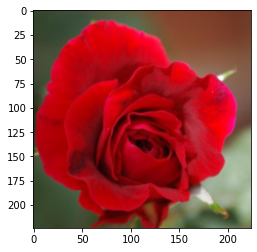

In [21]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax


imshow(rose_image.numpy())

## Prediction

TBD

In [22]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    # evaluation mode
    # https://pytorch.org/docs/stable/nn.html#torch.nn.Module.eval
    model.eval()

    # cpu mode
    model.cpu()

    # load image as torch.Tensor
    image = process_image(image_path)

    # Unsqueeze returns a new tensor with a dimension of size one
    # https://pytorch.org/docs/stable/torch.html#torch.unsqueeze
    image = image.unsqueeze(0)

    # Disabling gradient calculation 
    # (not needed with evaluation mode?)
    with torch.no_grad():
        output = model.forward(image)
        top_prob, top_labels = torch.topk(output, topk)

        # Calculate the exponentials
        top_prob = top_prob.exp()

    class_to_idx_inv = {model.class_to_idx[k]: k for k in model.class_to_idx}
    mapped_classes = list()

    for label in top_labels.numpy()[0]:
        mapped_classes.append(class_to_idx_inv[label])

    return top_prob.numpy()[0], mapped_classes

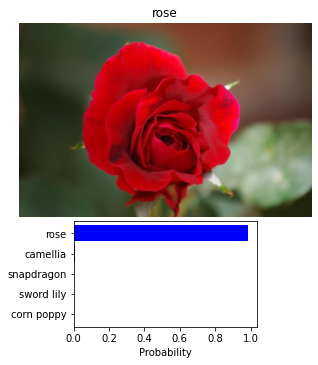

Correct classification: rose
Correct prediction: True


In [23]:
# Display an image along with the top 5 classes

chk_image_file = rose_dir+random_rose
correct_class = text_labels[74 - 1]

top_prob, top_classes = predict(chk_image_file, saved_model)

top_category = top_classes[0]


fig = plt.figure(figsize=(6, 6))
sp_img = plt.subplot2grid((15, 9), (0, 0), colspan=9, rowspan=9)
sp_prd = plt.subplot2grid((15, 9), (9, 2), colspan=5, rowspan=5)

image = Image.open(chk_image_file)
sp_img.axis('off')
sp_img.set_title(f'{text_labels[int(top_category) - 1]}')
sp_img.imshow(image)

labels = []
for class_idx in top_classes:
    labels.append(text_labels[int(class_idx) - 1])

yp = np.arange(5)
sp_prd.set_yticks(yp)
sp_prd.set_yticklabels(labels)
sp_prd.set_xlabel('Probability')
sp_prd.invert_yaxis()
sp_prd.barh(yp, top_prob, xerr=0, align='center', color='blue')

plt.show()

print(f'Correct classification: {correct_class}')
print('Correct prediction: '
      f'{correct_class == text_labels[int(top_category) - 1]}')